In [1]:
import json
import yaml
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# Project root (one level above notebooks/)
ROOT = Path(__vsc_ipynb_file__).resolve().parent.parent if "__vsc_ipynb_file__" in dir() else Path.cwd().parent
ARTIFACTS = ROOT / "artifacts"

# Load dataset config
with open(ROOT / "configs" / "datasets.yaml") as f:
    cfg = yaml.safe_load(f)

ref_name = cfg["reference"]["name"]
candidates = list(cfg["candidates"].keys())

def pretty(name):
    """Human-friendly dataset label."""
    return name.replace("_", "-")

print(f"Reference : {pretty(ref_name)}")
print(f"Candidates: {[pretty(c) for c in candidates]}")

Reference : openimages
Candidates: ['scannetpp', 'hypersim', 'gta-sfm']


In [3]:
# ── Load embedding metadata ────────────────────────────────────────────────
emb_stats = {}
for name in [ref_name] + candidates:
    meta_path = ARTIFACTS / "embeddings" / name / "meta.json"
    if meta_path.exists():
        with open(meta_path) as f:
            emb_stats[name] = json.load(f)

# ── Load retrieval similarities (1-NN) ─────────────────────────────────────
retrieval_sims = {}
for cand in candidates:
    sim_path = ARTIFACTS / "retrieval" / f"{ref_name}_{cand}" / "nn_sim.npy"
    if sim_path.exists():
        retrieval_sims[cand] = np.load(sim_path)

# ── Load aggregated weights ────────────────────────────────────────────────
weights_dir = ARTIFACTS / "weights" / ref_name
weights, counts = {}, {}
if (weights_dir / "weights.json").exists():
    with open(weights_dir / "weights.json") as f:
        weights = json.load(f)
    with open(weights_dir / "counts.json") as f:
        counts = json.load(f)

In [4]:
# ── Summary table ──────────────────────────────────────────────────────────
ref_count = emb_stats.get(ref_name, {}).get('count', 0)
total_wins = sum(counts.get(c, 0) for c in candidates)

cols = [("Dataset", "<15"), ("Size", ">10"), ("Weight", ">8"),
        ("Mean Sim", ">10"), ("Wins", ">8"), ("Win %", ">7")]
header = "  ".join(f"{name:{fmt}}" for name, fmt in cols)
print(header)
print("-" * len(header))

for cand in candidates:
    size = emb_stats.get(cand, {}).get('count', 0)
    w = weights.get(cand, 0)
    mean_sim = float(np.mean(retrieval_sims[cand])) if cand in retrieval_sims else 0
    wins = counts.get(cand, 0)
    win_pct = 100 * wins / total_wins if total_wins > 0 else 0
    print(f"{pretty(cand):<15}  {size:>10,}  {w:>8.3f}  {mean_sim:>10.4f}  {wins:>8,}  {win_pct:>6.1f}%")

print(f"\nReference: {pretty(ref_name)} ({ref_count:,} images)")

Dataset                Size    Weight    Mean Sim      Wins    Win %
--------------------------------------------------------------------
scannetpp         1,061,026     0.559      0.3057    55,946    55.9%
hypersim             74,619     0.257      0.2611    25,674    25.7%
gta-sfm              17,062     0.184      0.2015    18,410    18.4%

Reference: openimages (100,030 images)


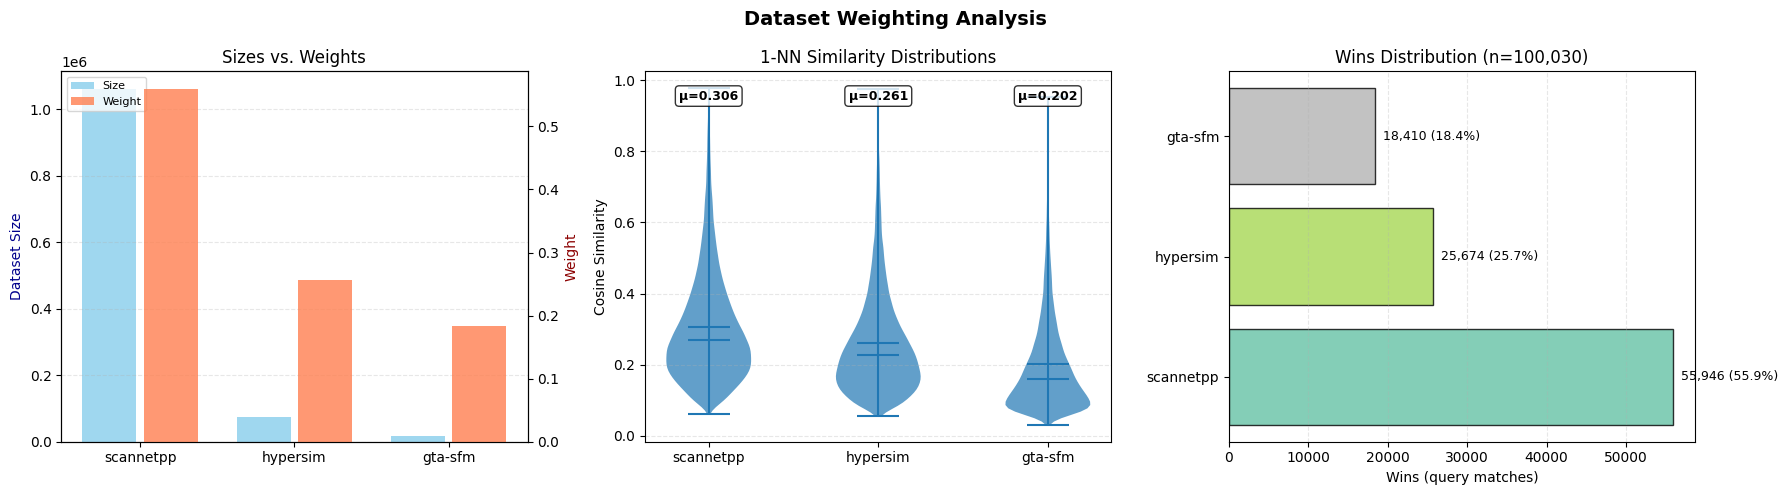

In [5]:
# ── Visualizations ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Dataset Weighting Analysis", fontsize=14, fontweight="bold")

n = len(candidates)
x = np.arange(n)
labels = [pretty(c) for c in candidates]

# ── Plot 1: Dataset sizes vs assigned weights ──────────────────────────────
ax = axes[0]
sizes = [emb_stats.get(c, {}).get('count', 0) for c in candidates]
w_vals = [weights.get(c, 0) for c in candidates]

ax.bar(x - 0.2, sizes, 0.35, color="skyblue", alpha=0.8, label="Size")
ax.set_ylabel("Dataset Size", color="darkblue")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("Sizes vs. Weights")

ax2 = ax.twinx()
ax2.bar(x + 0.2, w_vals, 0.35, color="coral", alpha=0.8, label="Weight")
ax2.set_ylabel("Weight", color="darkred")

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc="upper left", fontsize=8)
ax.grid(axis="y", alpha=0.3, linestyle="--")

# ── Plot 2: 1-NN similarity distributions ─────────────────────────────────
ax = axes[1]
sim_data = [retrieval_sims[c] for c in candidates if c in retrieval_sims]
sim_labels = [pretty(c) for c in candidates if c in retrieval_sims]

if sim_data:
    vp = ax.violinplot(sim_data, showmeans=True, showmedians=True)
    for body in vp["bodies"]:
        body.set_alpha(0.7)
    ax.set_xticks(range(1, len(sim_labels) + 1))
    ax.set_xticklabels(sim_labels)

    for i, d in enumerate(sim_data):
        ax.text(i + 1, ax.get_ylim()[1] * 0.95, f"\u03bc={np.mean(d):.3f}",
                ha="center", va="top", fontsize=9, fontweight="bold",
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

ax.set_ylabel("Cosine Similarity")
ax.set_title("1-NN Similarity Distributions")
ax.grid(axis="y", alpha=0.3, linestyle="--")

# ── Plot 3: Wins distribution ─────────────────────────────────────────────
ax = axes[2]
win_vals = [counts.get(c, 0) for c in candidates]
colors = plt.cm.Set2(np.linspace(0, 1, n))

bars = ax.barh(x, win_vals, color=colors, edgecolor="black", alpha=0.8)
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.set_xlabel("Wins (query matches)")
ax.set_title(f"Wins Distribution (n={total_wins:,})")

for cnt, bar in zip(win_vals, bars):
    pct = 100 * cnt / total_wins if total_wins > 0 else 0
    ax.text(bar.get_width() + total_wins * 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{cnt:,} ({pct:.1f}%)", va="center", fontsize=9)

ax.grid(axis="x", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()